In [1]:
from pynq import Overlay

ol = Overlay('pynq_sdr.bit')
ol.axi_dma.recvchannel # Touch to wake
ol.axi_dma.sendchannel # Touch to wake

In [2]:
from rtlsdr import RtlSdr
from pylab import *

sdr = RtlSdr()
sdr.sample_rate = 2.048e6  # Hz
sdr.center_freq = 101.7e6 # Hz
sdr.gain = 'auto'

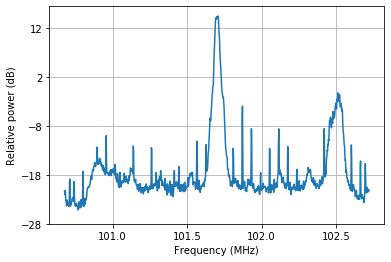

In [3]:
buffer_length = 131072
samples = sdr.read_samples(buffer_length)

psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
xlabel('Frequency (MHz)')
ylabel('Relative power (dB)')

show()

In [4]:
# configure device
sdr.center_freq = 101.7e6 # Hz

In [5]:
import asyncio
import threading
import scipy as sp
import numpy as np
from scipy import signal
from pynq import allocate
import time

data = []
data.append(np.ones(shape=(8000,), dtype=np.single))
data.append(np.ones(shape=(8000,), dtype=np.single))
data.append(np.ones(shape=(8000,), dtype=np.single))
mydata = None

buffer_length = 512000

global_counter = 0

tx_buffer = allocate(shape=(buffer_length,), dtype=np.csingle)
rx_buffer = allocate(shape=(int(buffer_length/64),), dtype=np.single)

def generate_wav(sample_rate, bits_per_sample, channels, samples):
    datasize = samples * channels * bits_per_sample // 8
    o = bytes("RIFF",'ascii')                                                 # (4byte) Marks file as RIFF
    o += (datasize + 36).to_bytes(4,'little')                                 # (4byte) File size in bytes excluding this and RIFF marker
    o += bytes("WAVE",'ascii')                                                # (4byte) File type
    o += bytes("fmt ",'ascii')                                                # (4byte) Format Chunk Marker
    o += (16).to_bytes(4,'little')                                            # (4byte) Length of above format data
    o += (3).to_bytes(2,'little')                                             # (2byte) Format type (1 - PCM)
    o += (channels).to_bytes(2,'little')                                      # (2byte)
    o += (sample_rate).to_bytes(4,'little')                                   # (4byte)
    o += (sample_rate * channels * bits_per_sample // 8).to_bytes(4,'little') # (4byte)
    o += (channels * bits_per_sample // 8).to_bytes(2,'little')               # (2byte)
    o += (bits_per_sample).to_bytes(2,'little')                               # (2byte)
    o += bytes("data",'ascii')                                                # (4byte) Data Chunk Marker
    o += (datasize).to_bytes(4,'little')                                      # (4byte) Data size in bytes
    return o

def audio_callback():
    global data
    yield generate_wav(
        sample_rate=32000,
        bits_per_sample=32,
        channels=1,
        samples=int(2**28))
    while True:
        if data:
            tempdata = data.pop().tobytes()
            yield tempdata
        else:
            time.sleep(1)

def default_callback(samples):
    global global_counter
    global data
    tx_buffer[:] = samples[:]
    ol.axi_dma.recvchannel.transfer(rx_buffer)
    ol.axi_dma.sendchannel.transfer(tx_buffer)
    ol.axi_dma.sendchannel.wait()
    ol.axi_dma.recvchannel.wait()
    data.append(np.array(rx_buffer))
    if len(data) >= 10:
        data.pop()
    global_counter += 1

class AsyncRtlSdr():
    """Class for streaming RTL-SDR samples from USB device
    to the Zynq's PS.
    """
    def __init__(self,
                 sdr,
                 buffer_length = buffer_length,
                 func_callback = [default_callback]):
        """Create new asynchronous RTL-SDR class.
        """
        self._stopping = True
        self._loop = asyncio.get_event_loop()
        self._buffer_length = buffer_length
        self.sdr = sdr
        self.callback = func_callback
        
    async def _stream(self):
        start = time.time()
        async for samples in self.sdr.stream(self._buffer_length):
            for callback in self.callback:
                callback(samples.astype(np.csingle)[:])
        end = time.time()
        print(end-start)
                
    def _do(self):
        future = asyncio.run_coroutine_threadsafe(self._stream(), self._loop)
        future.result()
                
    def start(self):
        thread = threading.Thread(target=self._do)
        thread.start()
        

In [6]:
async_sdr = AsyncRtlSdr(sdr=sdr)

In [7]:
async_sdr.start()

In [8]:
from flask import Flask, Response
import threading

app = Flask(__name__)

@app.route("/live.wav")
def live():  
    return Response(audio_callback(), mimetype="audio/x-wav")

from werkzeug.serving import run_simple
t = threading.Thread(target=lambda: run_simple('192.168.1.112', 8866, app, threaded=True)).start()

In [9]:
import IPython.display as display

display.Audio(url="http://192.168.1.112:8866/live.wav")

 * Running on http://192.168.1.112:8866/ (Press CTRL+C to quit)
192.168.1.107 - - [14/Mar/2022 21:56:49] "GET /live.wav HTTP/1.1" 200 -


In [14]:
sdr.center_freq = 101.7e6 # Hz

In [13]:
# Celtic Music Radio
sdr.center_freq = 95e6 # Hz

In [12]:
# Clyde 1
sdr.center_freq = 102.5e6 # Hz

In [ ]:
# Smooth Radio
sdr.center_freq = 106.1 # Hz